In [ ]:
# Import Jax Libraries
import jax.numpy as jnp
from jax.lax import fori_loop
from jax.nn import relu, tanh
from jax import grad, jit, vmap, random
#from jax.config import config; config.update("jax_enable_x64", True)

# Import Other Lirbaries
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Hamiltonian Monte Carlo -- Tutorial
Hamiltonian Monte Carlo (HMC) is a powerful Markov chain Monte Carlo (MCMC) algorithm for sampling from distributions that is commonly used for inference with Bayesian Neural Networks (BNNs). HMC is also known as Hybrid Monte Carlo because it combines the Metropolis-Hastings algorithm with Hamiltonian dynamic.

## How HMC works
HMC samples from the target distribution by proposing new states of a chain using a Hamiltonian dynamics simulation. The Hamiltonian dynamics are defined by a Hamiltonian function that describes the energy of the system being sampled.

At each iteration, HMC chooses a random starting point in the state space and then simulates the dynamics of the system by solving the Hamiltonian equations of motion using a numerical integration scheme such as leapfrog integration. The simulated dynamics are used to propose a new state of the chain. The proposal is accepted or rejected using the Metropolis-Hastings acceptance probability that depends on the ratio of the probabilities of the proposed state and the current state.

## Advantages of HMC
Compared to other MCMC algorithms such as the random walk Metropolis algorithm, HMC has several advantages:

- It generates proposals that are highly correlated with the current state, resulting in fewer rejections and faster convergence to the target distribution.
- It can explore the target distribution more efficiently by exploiting the geometry of the distribution.
- It can sample from distributions with complex geometries that are difficult for other MCMC algorithms.

## Limitations of HMC
Although HMC has several advantages, it has some limitations:

- It requires specifying the Hamiltonian function, which can be difficult for some distributions.
- The choice of the integration step size and the number of integration steps can significantly affect the performance of the algorithm. These parameters need to be carefully tuned to ensure good performance.
- The computational cost of simulating the dynamics can be high, especially for high-dimensional distributions.


In [ ]:
@partial(jit, static_argnums=[4,])
def leapfrog_step(p, x_new, g_new, eps, d_post_func):
  """ Leapfrog integrator for the Hamiltonian Dynamics """
  p_half = p - (eps/2.0) * g_new
  x_next = x_new + eps*p_half
  g_next = d_post_func(x_next)
  p_next = p_half - (eps/2.0) * g_next
  return p_next, x_next, g_next

def hmc(params_init, post_func, d_post_func, eps, L, n_samples, burn_in, key, display=False):
  """ HMC with adaptive step size learned during burn-in (acceptance rate ~.6) """
  accept_rate = 0.6
  lookback_window = 10
  x = params_init
  in_dim = len(params_init)
  params_list = [[],]*n_samples
  accept_list = [[],]*(n_samples+burn_in)
  eps_list = np.zeros(lookback_window)
  E = post_func(x)
  dE = d_post_func(x)
  for n in range(n_samples + burn_in):
    key_use, key_use_2, key = random.split(key,3)
    p = random.normal(key_use, shape=(in_dim,1))
    H = E + jnp.sum(p**2)/(2.0) 
    x_new = x; g_new = dE
    #Leapfrog steps
    for _ in range(L):
      p, x_new, g_new = leapfrog_step(p, x_new, g_new, eps, d_post_func)
    E_new = post_func(x_new)
    dE_new = d_post_func(x_new)
    H_new = jnp.sum(p**2)/(2.0) + E_new
    dH = H_new - H
    #Metropolis hastings
    if dH < 0 or random.uniform(key_use_2,shape=(1,)) < jnp.exp(-dH): accept = 1
    else:                                                             accept = 0
    if accept: dE = dE_new; x = x_new; E = E_new
    accept_list[n] = accept
    if n>=burn_in: 
        params_list[n-burn_in] = np.array(x)
        eps = np.exp(np.mean(np.log(eps_list)))
    #If >.6 acceptance rate, increase eps, else decrease acceptance rate
    elif n>=lookback_window:
        if np.sum(accept_list[n-(lookback_window-1):n+1])/lookback_window > accept_rate: 
          eps *= 1.01
        else:
          eps /= 1.01
        eps_list[1:] = eps_list[:-1]
        eps_list[0] = eps 
    if display == True:
      print('Log-Posterior:',E,' - eps:',eps)
  params_list = np.array(params_list).squeeze().T
  return params_list, accept_list, eps

# Bayesian Physics-Informed Neural Networks (B-PINN) 

Bayesian Physics-Informed Neural Networks (B-PINN) is a machine learning method that combines Bayesian neural networks with physics-informed neural networks to solve inverse problems in scientific and engineering applications. B-PINN provides a powerful and flexible framework for integrating physical laws and experimental data into the training of neural networks, enabling accurate predictions and uncertainty quantification.

## How does B-PINN work?

We consider the following partial differential equation (PDE): 
\begin{align}
\mathcal{N}_x(u(\mathbf{x});\boldsymbol{\lambda})&=f(\mathbf{x}) \quad \mathbf{x}\in \Omega,\\
\mathcal{B}_x(u(\mathbf{x});\boldsymbol{\lambda})&=b(\mathbf{x}) \quad \mathbf{x}\in \partial\Omega,
\end{align}
where $\mathcal{N}_x$ and $\mathcal{B}_x$ denote the differential and boundary operators, respectively. The spatial domain $\Omega\subseteq\mathbb{R}^d$ has boundary $\Gamma$, and $\boldsymbol{\lambda}\in\mathbb{R}^{N_\lambda}$ represents a vector of unknown physical parameters. The forcing function $f(\mathbf{x})$ and boundary function $b(\mathbf{x})$ are given, and $u(\mathbf{x})$ is the solution of the PDE. We approximate the solution $u(\mathbf{x})$ with a neural network approximation $\tilde{u}(\mathbf{x};\boldsymbol{\theta}).$ Here $\boldsymbol{\theta}$ represents the weights and biases of the neural network approximations. Additionally, we denote the quantity $\boldsymbol{\xi}=[\boldsymbol{\theta},\boldsymbol{\lambda}]$ to be the total set of physical and neural network parameters. In this setting, we have access to to $N_u$ measurements $$\mathcal{D}_u=\{(\mathbf{x}_u^i,u(\mathbf{x}_u^i))\}_{i=1}^{N_u}=\{(\mathbf{x}_u^i, u^i)\}_{i=1}^{N_u}$$ of the forward solution $u(\mathbf{x})$. Additionally, we utilize information from the PDE and boundary, denoted "residual points" and "boundary points," respectively, as follows:
\begin{align}
    \mathcal{D}_f =\{(\mathbf{x}_f^i,f(\mathbf{x}_f^i))\}_{i=1}^{N_f}= \{(\mathbf{x}_f^i,f^i)\}_{i=1}^{N_f}\\
    \mathcal{D}_b =\{(\mathbf{x}_b^i,b(\mathbf{x}_b^i))\}_{i=1}^{N_b} = \{(\mathbf{x}_b^i,b^i)\}_{i=1}^{N_b},
\end{align} 
with residual locations $\mathbf{x}_f^i\in \Omega$ and boundary locations $\mathbf{x}_b^i\in \partial\Omega$. Bayesian PINNs place the following assumptions on the likelihood functions $p(\mathcal{D}_u,\mathcal{D}_f,\mathcal{D}_b|\boldsymbol{\xi})$ of the three groups of measurements

\begin{align}
p(\mathcal{D}_u,\mathcal{D}_f,\mathcal{D}_b|\boldsymbol{\xi})&=p(\mathcal{D}_u|\boldsymbol{\xi})p(\mathcal{D}_f|\boldsymbol{\xi})p(\mathcal{D}_b|\boldsymbol{\xi}),\\
p(\mathcal{D}_u|\boldsymbol{\xi}) &= \prod_{i=1}^{N_u}p(u^i|\boldsymbol{\xi}),\quad
p(\mathcal{D}_f|\boldsymbol{\xi}) = \prod_{i=1}^{N_f}p(f^i|\boldsymbol{\xi}),\quad
p(\mathcal{D}_b|\boldsymbol{\xi}) = \prod_{i=1}^{N_b}p(b^i|\boldsymbol{\xi}),\\
p(u^i|\boldsymbol{\xi})&=\frac{1}{\sqrt{2\pi\sigma_{\eta_u}^2}}\exp\left(-\frac{\left(u^i-\tilde{u}(\mathbf{x}_u^i;\boldsymbol{\theta})\right)^2}{2\sigma_{\eta_u}^2}\right),\\
p(f^i|\boldsymbol{\xi})&=\frac{1}{\sqrt{2\pi\sigma_{\eta_f}^2}}\exp\left(-\frac{\left(f^i-\mathcal{N}_x(\tilde{u}(\mathbf{x}_f^i;\boldsymbol{\theta});\boldsymbol{\lambda})\right)^2}{2\sigma_{\eta_f}^2}\right),\\
p(b^i|\boldsymbol{\xi})&=\frac{1}{\sqrt{2\pi\sigma_{\eta_b}^2}}\exp\left(-\frac{\left(b^i-\mathcal{B}_x(\tilde{u}(\mathbf{x}_b^i;\boldsymbol{\theta});\boldsymbol{\lambda})\right)^2}{2\sigma_{\eta_b}^2}\right).
\end{align}
Here, $\sigma_{\eta_u}$, $\sigma_{\eta_f}$, $\sigma_{\eta_b}$ are the standard deviations of the forward measurements, residual points, and boundary points, and are typically assumed known a priori. Additionally, the following form of the prior $p(\boldsymbol{\xi})$ is typically assumed
\begin{align}
p(\boldsymbol{\xi})&= p(\boldsymbol{\lambda})p(\boldsymbol{\theta})\\
p(\boldsymbol{\theta}) &= \prod_{i=1}^{N_\theta} p(\theta^i), \quad
p(\theta^i) \sim \mathcal{N}\left(0,\sigma^i_\theta\right),\\
p(\boldsymbol{\lambda}) &= \prod_{i=1}^{N_\lambda} p(\lambda^i), \quad p(\lambda^i) \sim \mathcal{N}\left(0,\sigma^i_\lambda\right).
\end{align}
Here  $\sigma_{\lambda}$, $\sigma_{\theta}$ are the prior physical and neural network parameter standard deviations, respectively. From here, we can formulate the posterior distribution $p(\boldsymbol{\xi}|\mathcal{D}_u,\mathcal{D}_f,\mathcal{D}_b)$ using Bayes theorem
\begin{align}
p(\boldsymbol{\xi}|\mathcal{D}_u,\mathcal{D}_f,\mathcal{D}_b)&\propto p(\boldsymbol{\xi})p(\mathcal{D}_u,\mathcal{D}_f,\mathcal{D}_b|\boldsymbol{\xi}),
\end{align}
and we may apply any inference method if interest to perform inference on the physical and nerual network parameters.

![B-PINN Flow Chart](https://drive.google.com/uc?id=1UvxadtquFBS_F7wIOY6NRJyTHa0poXRp)

# B-PINN Advantages
Compared to other inverse problem solvers, B-PINN has several advantages:

- It can handle noisy and incomplete experimental data by providing probabilistic estimates of the solution and its uncertainty.
- It can incorporate physical laws and constraints into the training of neural networks, enabling accurate predictions and better generalization.
- It can handle complex and nonlinear systems, as neural networks are universal approximators.
- It can reduce the computational cost of solving inverse problems, as the physics-informed neural network can provide accurate and fast surrogate models.



# Limitations of B-PINN
Despite its many advantages, B-PINN also has some limitations that should be taken into consideration:

- The training process of B-PINN can be computationally expensive, particularly when dealing with large datasets or high-dimensional parameter spaces. This may require the use of specialized hardware or distributed computing resources.
- The choice of the prior distributions for the physical and neural network parameters can have a significant impact on the performance of B-PINN. 
- The choice of hyperparameters for the likelihood function can be challenging, particularly for the boundary and residual points when the physics information is assumed to be noise-free.

In [ ]:
@jit
def layer(x, A, b):
  return x@A + b

@partial(jit, static_argnums=[2,3,4,5,6])
def NN(x, params, n_in, n_hidden, n_out, num_layers, activation=tanh):
  """ Neural network function, utilizes flattened parameters vector """
  #Input layers
  n_last = 0
  A = jnp.reshape(params[n_last:n_last+n_in*n_hidden],(n_in,n_hidden))
  n_last = n_last+n_in*n_hidden
  b = jnp.reshape(params[n_last:n_last+n_hidden],(1,n_hidden))
  x = layer(x, A, b)
  x = activation(x)

  #Hidden layers
  for i in range(num_layers):
    A = jnp.reshape(params[n_last:n_last+n_hidden**2],(n_hidden,n_hidden))
    n_last = n_last+n_hidden**2
    b = jnp.reshape(params[n_last:n_last+n_hidden],(1,n_hidden))
    x = layer(x, A, b)
    x = activation(x)

  #output layers
  A = jnp.reshape(params[n_last:n_last+n_hidden*n_out],(n_hidden,n_out))
  n_last = n_last+n_hidden*n_out
  b = jnp.reshape(params[n_last:n_last+n_out],(1,n_out))
  x = layer(x, A, b)
  return x

def get_n_params_nn(n_in, n_hidden, n_out, num_layers):
  """ Gets the number of parameters to create for the NN"""
  in_num = n_hidden + n_hidden*n_in
  out_num = n_out + n_out*n_hidden
  hidden_num = (n_hidden + n_hidden**2)
  return in_num + hidden_num*(num_layers) + out_num

## Example 1 - Nonlinear 1D Poisson
$$\lambda u_{xx} + k\tanh(u) = f(x)$$
$$u(-0.7)  = \sin^3(6(-0.7))$$ 
$$u(0.7) = \sin^3(6(0.7))$$
$$u = \sin^3(6x)$$
$$f(x) = \lambda\big(-108 \sin(6 x) (\sin^2(6 x) - 2 \cos^2(6 x))\big) + k\tanh(\sin^3(6x))$$
$$\lambda = 0.01$$
$$k = 0.7$$


[Source](https://www.sciencedirect.com/science/article/pii/S0021999120306872)

In [ ]:
key_u = random.PRNGKey(0)

# True functions
def f_func(x, k=0.7):
  lam = 0.01
  return k*jnp.tanh(jnp.sin(6*x)**3) - 108*lam*jnp.sin(6*x)*(jnp.sin(6*x)**2 - 2*jnp.cos(6*x)**2)

def u_func(x):
  return jnp.sin(6*x)**3

def bd_func(x):
  return u_func(x)

# Physical Parameter
k = 0.7

# Number of samples
n_u = 8
n_bd = 2
n_f = 32

#Number of parameters
n_hidden = 50
n_layers = 2
n_in = 1
n_out = 1
n_nn = get_n_params_nn(n_in, n_hidden, n_out, n_layers)
n_lam = 1
n_params = n_nn + n_lam

# Bounds
lb = -0.7
ub = 0.7

# Locations
x_u_plus_bd = jnp.expand_dims(jnp.linspace(lb, ub, n_u + n_bd),1)

x_u = x_u_plus_bd[1:-1,:]
x_f = jnp.expand_dims(jnp.linspace(lb, ub, n_f),1)
x_bd = x_u_plus_bd[[0,-1],:]

# Data
sig_u_true = 0.1
noise_u = random.normal(key_u,(n_u,1))
u_data = u_func(x_u) + sig_u_true*noise_u  #Noisy Data
bd_data = bd_func(x_bd)                    #Noise-free Data
f_data = f_func(x_f)                       #Noise-free Data
y = jnp.concatenate((u_data, bd_data, f_data))

# Likelihood Covariance
sig_u = 0.1
sig_f = 0.1
sig_bd = 0.1
R_u = sig_u**2*np.ones(n_u)
R_bd = sig_bd**2*np.ones(n_bd)
R_f = sig_f**2*np.ones(n_f)
R = jnp.concatenate((R_u,R_bd,R_f))

# Prior Covariance
std_theta = 1.0
std_lambda = 1.0
C_lambda = std_lambda**2*np.ones(n_lam)
C_theta = std_theta**2*np.ones(n_nn)
C0 = jnp.concatenate((C_lambda,C_theta))

# Derivative operators - params = [theta]
NN_ew = lambda x, params: NN(x.reshape(-1,1), params, n_in, n_hidden, n_out, n_layers).reshape()
NN_ew_x = lambda x, params: grad(NN_ew)(x, params).reshape()
NN_ew_xx = lambda x, params: grad(NN_ew_x)(x, params).reshape()

# PINN Operators - params = [k, theta]
f_op_ew = jit(lambda x, params: 0.01*NN_ew_xx(x, params[1:]) + params[0]*tanh(NN_ew(x,params[1:])))
u_op_ew = jit(lambda x, params: NN_ew(x, params[1:]))
bd_op_ew = jit(lambda x, params: NN_ew(x, params[1:]))

u_op = lambda x, X: vmap(vmap(u_op_ew,(0, None)),(None,1))(x,X).T
bd_op = lambda x, X: vmap(vmap(bd_op_ew,(0, None)),(None,1))(x,X).T
f_op = lambda x, X:  vmap(vmap(f_op_ew,(0, None)),(None,1))(x,X).T
h_op = jit(lambda X: jnp.concatenate((u_op(x_u,X),bd_op(x_bd,X),f_op(x_f,X))))

#Testing dataset
x_test = np.linspace(lb,ub,1000)
u_truth = u_func(x_test)

In [ ]:
#HMC hyperparameters
nl_prior = lambda X, C0: 0.5*(jnp.sum((X)**2/C0.reshape(-1,1)) + len(C0)*np.log(2*np.pi) + jnp.sum(jnp.log(C0)))
nl_likelihood = lambda X, y, h, R: 0.5*(jnp.sum((h(X)-y)**2/R.reshape(-1,1)) + len(R)*np.log(2*np.pi) + jnp.sum(jnp.log(R)))
nl_post = lambda X: nl_likelihood(X, y, h_op, R) + nl_prior(X, C0)

d_nl_post = grad(nl_post,0)
step_size = 1e-2
L = 50
n_samples = 1000
burn_in = 1000

# HMC - Running
key_hmc, key_X0 = random.split(random.PRNGKey(1))
X_0 = 0*C0.reshape(-1,1)*random.normal(key_X0,(n_params,1))
X_hmc, accept_list, eps = hmc(X_0, nl_post, d_nl_post, step_size, L, n_samples, burn_in, key_hmc, display=False)
u_sims = u_op(x_test.reshape(-1,1), X_hmc)

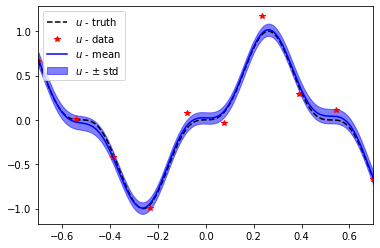

In [ ]:
# Plotting
u_mean = np.mean(u_sims,axis=1)
u_std = np.std(u_sims,axis=1)

plt.plot(x_test, u_truth,'k--',label='$u$ - truth')
plt.plot(x_u, u_data,'r*',label='$u$ - data')
plt.plot(x_bd, bd_data,'r*')
plt.plot(x_test, u_mean,'b-',label='$u$ - mean')
plt.fill_between(x_test, u_mean - u_std, u_mean + u_std, color='blue', alpha=0.5, label="$u$ - $\\pm$ std") #Results +/- 1 std
plt.xlim(lb,ub)
plt.legend()
plt.show()
